In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Load MNIST Dataset
(x_train, _), (_, _) = mnist.load_data()
# Normalize pixel values to range [-1, 1]
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1)
print(f"Training data shape: {x_train.shape}")

Training data shape: (60000, 28, 28, 1)


In [3]:
x_train

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [4]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

In [5]:
# Set latent dimension
latent_dim = 100
generator = build_generator(latent_dim)
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

In [6]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
# Set input image shape
img_shape = (28, 28, 1)
discriminator = build_discriminator(img_shape)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)              

In [8]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5),metrics=['accuracy'])

In [9]:
def build_gan(generator, discriminator):
    model = Sequential()
    # Add generator to the GAN
    model.add(generator)
    # Freeze discriminator's weights during generator training
    discriminator.trainable = False
    # Add discriminator to the GAN
    model.add(discriminator)
    return model

In [10]:
# Build and compile GAN
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [18]:
# validation
def sample_images(rows=4, cols=4):
    # Generate noise for sample images
    noise = np.random.normal(0, 1, (rows * cols, latent_dim))
    gen_imgs = generator.predict(noise)
    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    # Plot generated images
    fig, axs = plt.subplots(rows, cols, figsize=(4, 4))
    cnt = 0
    for i in range(rows):
        for j in range(cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [14]:
def train_gan(epochs, batch_size=128, sample_interval=100):
    # Load and preprocess data
    X_train = x_train
    half_batch = batch_size // 2
    # Labels for real and fake images
    real = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    
    for epoch in range(epochs):
        # Train the discriminator
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        # Generate a half batch of fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim)) # 0  mean 1 std gives 64-100 values
        gen_imgs = generator.predict(noise)
        # Train the discriminator (real classified as 1 and fake as 0)
        d_loss_real = discriminator.train_on_batch(imgs, real) # d_loss_real = accuracy, loss; train_on_batch same as model.fit
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # Train the generator
        # Generate noise for batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Train the generator (wants discriminator to label as real)
        real_g = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, real_g)
        # Print the progress
        print(f"{epoch + 1} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss:.4f}]")
        # Save generated image samples at intervals
        if (epoch + 1) % sample_interval == 0:
            sample_images()

1/1 [==============================] - 0s 27ms/step
1 [D loss: 0.6726, acc.: 48.44%] [G loss: 0.7014]
1/1 [==============================] - 0s 15ms/step
2 [D loss: 0.6224, acc.: 73.44%] [G loss: 0.7566]
1/1 [==============================] - 0s 15ms/step
3 [D loss: 0.6670, acc.: 60.94%] [G loss: 0.7707]
1/1 [==============================] - 0s 15ms/step
4 [D loss: 0.6342, acc.: 60.94%] [G loss: 0.7549]
1/1 [==============================] - 0s 13ms/step
5 [D loss: 0.6765, acc.: 57.81%] [G loss: 0.7621]
1/1 [==============================] - 0s 17ms/step
6 [D loss: 0.6521, acc.: 59.38%] [G loss: 0.7597]
1/1 [==============================] - 0s 14ms/step
7 [D loss: 0.6745, acc.: 56.25%] [G loss: 0.7360]
1/1 [==============================] - 0s 17ms/step
8 [D loss: 0.6271, acc.: 65.62%] [G loss: 0.7519]
1/1 [==============================] - 0s 15ms/step
9 [D loss: 0.6637, acc.: 59.38%] [G loss: 0.7327]
1/1 [==============================] - 0s 16ms/step
10 [D loss: 0.6260, acc.: 60.9

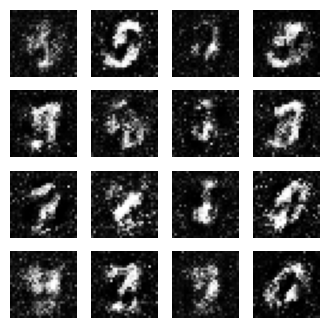

1/1 [==============================] - 0s 17ms/step
1001 [D loss: 0.7134, acc.: 54.69%] [G loss: 0.8015]
1/1 [==============================] - 0s 17ms/step
1002 [D loss: 0.6875, acc.: 59.38%] [G loss: 0.7458]
1/1 [==============================] - 0s 16ms/step
1003 [D loss: 0.7038, acc.: 45.31%] [G loss: 0.7249]
1/1 [==============================] - 0s 13ms/step
1004 [D loss: 0.7119, acc.: 50.00%] [G loss: 0.7656]
1/1 [==============================] - 0s 12ms/step
1005 [D loss: 0.6332, acc.: 64.06%] [G loss: 0.7742]
1/1 [==============================] - 0s 15ms/step
1006 [D loss: 0.6584, acc.: 59.38%] [G loss: 0.8375]
1/1 [==============================] - 0s 15ms/step
1007 [D loss: 0.6903, acc.: 53.12%] [G loss: 0.8204]
1/1 [==============================] - 0s 16ms/step
1008 [D loss: 0.6423, acc.: 60.94%] [G loss: 0.7635]
1/1 [==============================] - 0s 15ms/step
1009 [D loss: 0.6668, acc.: 60.94%] [G loss: 0.7618]
1/1 [==============================] - 0s 13ms/step
101

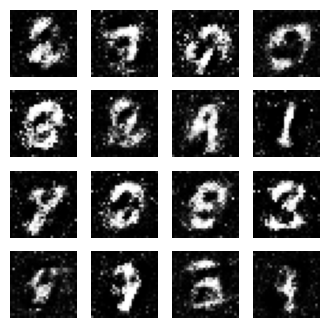

1/1 [==============================] - 0s 24ms/step
2001 [D loss: 0.6830, acc.: 62.50%] [G loss: 0.8586]
1/1 [==============================] - 0s 19ms/step
2002 [D loss: 0.6455, acc.: 65.62%] [G loss: 0.8027]
1/1 [==============================] - 0s 18ms/step
2003 [D loss: 0.6336, acc.: 71.88%] [G loss: 0.8300]
1/1 [==============================] - 0s 29ms/step
2004 [D loss: 0.6618, acc.: 60.94%] [G loss: 0.8762]
1/1 [==============================] - 0s 19ms/step
2005 [D loss: 0.6424, acc.: 67.19%] [G loss: 0.8339]
1/1 [==============================] - 0s 19ms/step
2006 [D loss: 0.6368, acc.: 64.06%] [G loss: 0.7736]
1/1 [==============================] - 0s 26ms/step
2007 [D loss: 0.6704, acc.: 56.25%] [G loss: 0.8890]
1/1 [==============================] - 0s 21ms/step
2008 [D loss: 0.7040, acc.: 53.12%] [G loss: 0.8175]
1/1 [==============================] - 0s 21ms/step
2009 [D loss: 0.6846, acc.: 65.62%] [G loss: 0.8200]
1/1 [==============================] - 0s 25ms/step
201

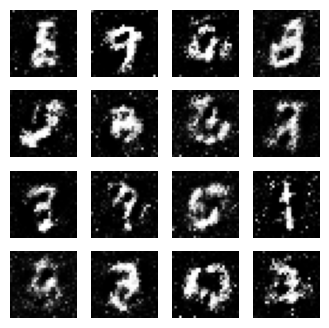

1/1 [==============================] - 0s 17ms/step
3001 [D loss: 0.6218, acc.: 56.25%] [G loss: 0.8168]
1/1 [==============================] - 0s 18ms/step
3002 [D loss: 0.6357, acc.: 56.25%] [G loss: 0.8082]
1/1 [==============================] - 0s 18ms/step
3003 [D loss: 0.6100, acc.: 71.88%] [G loss: 0.7708]
1/1 [==============================] - 0s 19ms/step
3004 [D loss: 0.6199, acc.: 75.00%] [G loss: 0.8227]
1/1 [==============================] - 0s 20ms/step
3005 [D loss: 0.6842, acc.: 57.81%] [G loss: 0.7626]
1/1 [==============================] - 0s 17ms/step
3006 [D loss: 0.7068, acc.: 57.81%] [G loss: 0.8165]
1/1 [==============================] - 0s 14ms/step
3007 [D loss: 0.6344, acc.: 62.50%] [G loss: 0.7914]
1/1 [==============================] - 0s 15ms/step
3008 [D loss: 0.6376, acc.: 64.06%] [G loss: 0.8332]
1/1 [==============================] - 0s 17ms/step
3009 [D loss: 0.7290, acc.: 48.44%] [G loss: 0.7517]
1/1 [==============================] - 0s 14ms/step
301

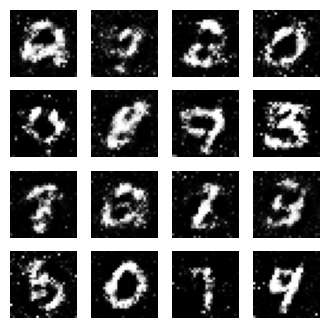

1/1 [==============================] - 0s 15ms/step
4001 [D loss: 0.6407, acc.: 59.38%] [G loss: 0.7696]
1/1 [==============================] - 0s 17ms/step
4002 [D loss: 0.7187, acc.: 50.00%] [G loss: 0.7424]
1/1 [==============================] - 0s 16ms/step
4003 [D loss: 0.6525, acc.: 57.81%] [G loss: 0.7432]
1/1 [==============================] - 0s 19ms/step
4004 [D loss: 0.6621, acc.: 56.25%] [G loss: 0.7868]
1/1 [==============================] - 0s 18ms/step
4005 [D loss: 0.6362, acc.: 59.38%] [G loss: 0.8143]
1/1 [==============================] - 0s 15ms/step
4006 [D loss: 0.7205, acc.: 42.19%] [G loss: 0.7849]
1/1 [==============================] - 0s 15ms/step
4007 [D loss: 0.6992, acc.: 59.38%] [G loss: 0.7365]
1/1 [==============================] - 0s 15ms/step
4008 [D loss: 0.7127, acc.: 57.81%] [G loss: 0.7881]
1/1 [==============================] - 0s 17ms/step
4009 [D loss: 0.7300, acc.: 43.75%] [G loss: 0.7452]
1/1 [==============================] - 0s 13ms/step
401

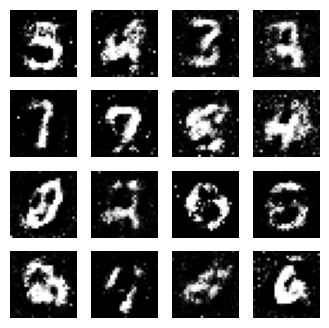

1/1 [==============================] - 0s 24ms/step
5001 [D loss: 0.6934, acc.: 54.69%] [G loss: 0.7974]
1/1 [==============================] - 0s 18ms/step
5002 [D loss: 0.6935, acc.: 48.44%] [G loss: 0.7881]
1/1 [==============================] - 0s 16ms/step
5003 [D loss: 0.7383, acc.: 45.31%] [G loss: 0.7668]
1/1 [==============================] - 0s 16ms/step
5004 [D loss: 0.6786, acc.: 57.81%] [G loss: 0.8013]
1/1 [==============================] - 0s 19ms/step
5005 [D loss: 0.6893, acc.: 57.81%] [G loss: 0.7884]
1/1 [==============================] - 0s 21ms/step
5006 [D loss: 0.6956, acc.: 51.56%] [G loss: 0.8343]
1/1 [==============================] - 0s 19ms/step
5007 [D loss: 0.7370, acc.: 45.31%] [G loss: 0.8090]
1/1 [==============================] - 0s 19ms/step
5008 [D loss: 0.6821, acc.: 57.81%] [G loss: 0.7656]
1/1 [==============================] - 0s 17ms/step
5009 [D loss: 0.7297, acc.: 50.00%] [G loss: 0.7478]
1/1 [==============================] - 0s 18ms/step
501

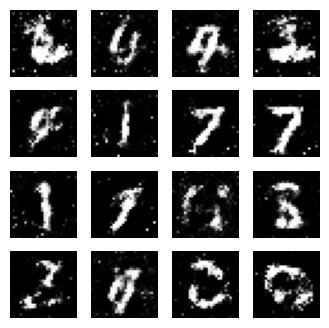

1/1 [==============================] - 0s 17ms/step
6001 [D loss: 0.6777, acc.: 54.69%] [G loss: 0.7442]
1/1 [==============================] - 0s 13ms/step
6002 [D loss: 0.6616, acc.: 53.12%] [G loss: 0.7591]
1/1 [==============================] - 0s 15ms/step
6003 [D loss: 0.6596, acc.: 56.25%] [G loss: 0.7690]
1/1 [==============================] - 0s 15ms/step
6004 [D loss: 0.6998, acc.: 54.69%] [G loss: 0.7773]
1/1 [==============================] - 0s 14ms/step
6005 [D loss: 0.6622, acc.: 53.12%] [G loss: 0.7619]
1/1 [==============================] - 0s 14ms/step
6006 [D loss: 0.6861, acc.: 53.12%] [G loss: 0.7612]
1/1 [==============================] - 0s 19ms/step
6007 [D loss: 0.6980, acc.: 54.69%] [G loss: 0.7700]
1/1 [==============================] - 0s 15ms/step
6008 [D loss: 0.6814, acc.: 53.12%] [G loss: 0.7432]
1/1 [==============================] - 0s 15ms/step
6009 [D loss: 0.6745, acc.: 59.38%] [G loss: 0.7697]
1/1 [==============================] - 0s 18ms/step
601

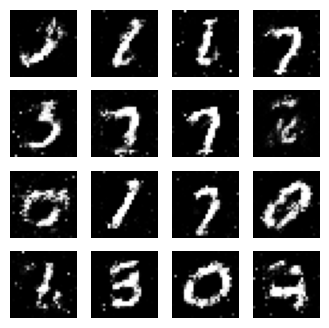

1/1 [==============================] - 0s 17ms/step
7001 [D loss: 0.6706, acc.: 53.12%] [G loss: 0.7727]
1/1 [==============================] - 0s 19ms/step
7002 [D loss: 0.6782, acc.: 59.38%] [G loss: 0.7337]
1/1 [==============================] - 0s 18ms/step
7003 [D loss: 0.6906, acc.: 50.00%] [G loss: 0.7319]
1/1 [==============================] - 0s 13ms/step
7004 [D loss: 0.6892, acc.: 54.69%] [G loss: 0.7758]
1/1 [==============================] - 0s 16ms/step
7005 [D loss: 0.7088, acc.: 56.25%] [G loss: 0.7660]
1/1 [==============================] - 0s 18ms/step
7006 [D loss: 0.7128, acc.: 46.88%] [G loss: 0.7811]
1/1 [==============================] - 0s 16ms/step
7007 [D loss: 0.7254, acc.: 54.69%] [G loss: 0.7754]
1/1 [==============================] - 0s 20ms/step
7008 [D loss: 0.7023, acc.: 50.00%] [G loss: 0.8028]
1/1 [==============================] - 0s 19ms/step
7009 [D loss: 0.6951, acc.: 57.81%] [G loss: 0.7539]
1/1 [==============================] - 0s 17ms/step
701

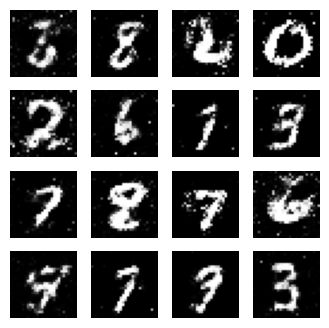

1/1 [==============================] - 0s 23ms/step
8001 [D loss: 0.6897, acc.: 54.69%] [G loss: 0.7151]
1/1 [==============================] - 0s 22ms/step
8002 [D loss: 0.7082, acc.: 54.69%] [G loss: 0.7171]
1/1 [==============================] - 0s 23ms/step
8003 [D loss: 0.6674, acc.: 59.38%] [G loss: 0.7518]
1/1 [==============================] - 0s 25ms/step
8004 [D loss: 0.7193, acc.: 48.44%] [G loss: 0.7182]
1/1 [==============================] - 0s 20ms/step
8005 [D loss: 0.6807, acc.: 59.38%] [G loss: 0.7044]
1/1 [==============================] - 0s 25ms/step
8006 [D loss: 0.6811, acc.: 56.25%] [G loss: 0.7603]
1/1 [==============================] - 0s 25ms/step
8007 [D loss: 0.6727, acc.: 60.94%] [G loss: 0.7188]
1/1 [==============================] - 0s 21ms/step
8008 [D loss: 0.7310, acc.: 45.31%] [G loss: 0.7074]
1/1 [==============================] - 0s 21ms/step
8009 [D loss: 0.7028, acc.: 54.69%] [G loss: 0.7404]
1/1 [==============================] - 0s 39ms/step
801

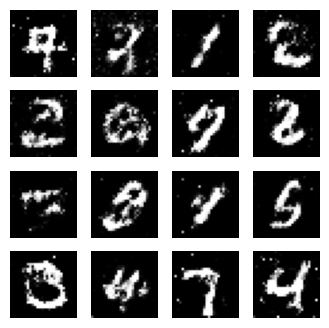

1/1 [==============================] - 0s 14ms/step
9001 [D loss: 0.6810, acc.: 51.56%] [G loss: 0.7578]
1/1 [==============================] - 0s 15ms/step
9002 [D loss: 0.6755, acc.: 57.81%] [G loss: 0.7427]
1/1 [==============================] - 0s 13ms/step
9003 [D loss: 0.7052, acc.: 50.00%] [G loss: 0.7554]
1/1 [==============================] - 0s 15ms/step
9004 [D loss: 0.7262, acc.: 37.50%] [G loss: 0.7397]
1/1 [==============================] - 0s 17ms/step
9005 [D loss: 0.7080, acc.: 40.62%] [G loss: 0.7435]
1/1 [==============================] - 0s 15ms/step
9006 [D loss: 0.6813, acc.: 56.25%] [G loss: 0.7140]
1/1 [==============================] - 0s 15ms/step
9007 [D loss: 0.7018, acc.: 53.12%] [G loss: 0.7213]
1/1 [==============================] - 0s 13ms/step
9008 [D loss: 0.7027, acc.: 51.56%] [G loss: 0.7385]
1/1 [==============================] - 0s 13ms/step
9009 [D loss: 0.6845, acc.: 53.12%] [G loss: 0.7500]
1/1 [==============================] - 0s 17ms/step
901

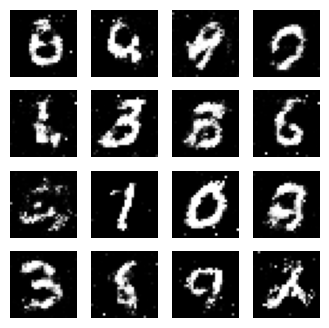

In [16]:
train_gan(epochs=10000, batch_size=64, sample_interval=1000)

1/1 [==============================] - 0s 16ms/step


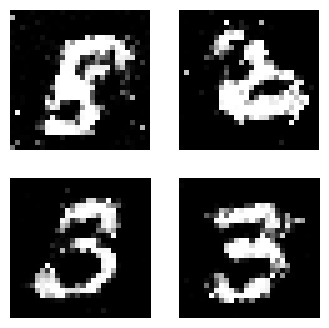

In [26]:
sample_images(rows=2,cols=2)

In [40]:
noise = np.random.normal(0, 1, (1, latent_dim))

1/1 [==============================] - 0s 20ms/step


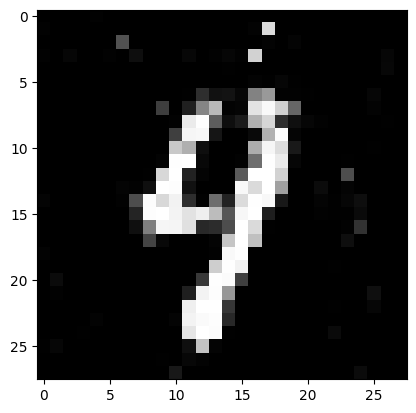

In [41]:
gen_imgs = generator.predict(noise)
# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
# Plot generated images
plt.imshow(gen_imgs[0],cmap='gray')

In [47]:
gan.save('gan-model')  # This saves the model in the TensorFlow SavedModel format
generator.save('generator-model')
discriminator.save('discriminator-model')

INFO:tensorflow:Assets written to: gan-model\assets
INFO:tensorflow:Assets written to: generator-model\assets
INFO:tensorflow:Assets written to: discriminator-model\assets


In [45]:
import tensorflow as tf

In [49]:
loaded_gan = tf.keras.models.load_model('gan-model')
loaded_generator = tf.keras.models.load_model('generator-model')
loaded_discriminator = tf.keras.models.load_model('discriminator-model')

1/1 [==============================] - 0s 80ms/step


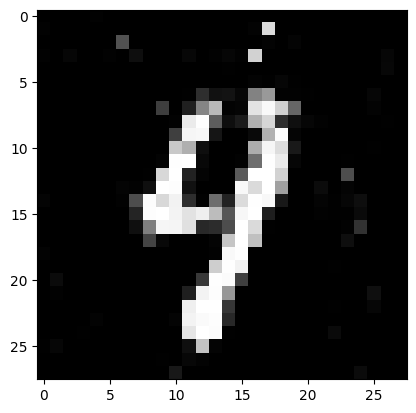

In [50]:
gen_imgs = loaded_generator.predict(noise)
# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
# Plot generated images
plt.imshow(gen_imgs[0],cmap='gray')